In [4]:
import pandas as pd
import numpy as np

## get the stock data 

In [97]:
# get the stock data
from google.cloud import storage
def get_amazn_stock_data_from_gcp(nrows=10000, local=False, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/amazon_stock_price.csv"
    df = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    return df


In [98]:
df_stocks = get_amazn_stock_data_from_gcp()

In [102]:
df_stocks = df_stocks.sort_values(["date"], ascending=True)

In [103]:
df_stocks.head()

,date,AMZN
5551,1999-11-01,69.13
5550,1999-11-02,66.44
5549,1999-11-03,65.81
5548,1999-11-04,63.06
5547,1999-11-05,64.94


## get the sentiment data

In [109]:
# get the data from GCP
from google.cloud import storage
def get_sentiment_news_data_from_gcp(nrows=10000, local=False, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/final_stocks_sentiment.csv"
    df = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    return df

In [110]:
sentiment = get_sentiment_news_data_from_gcp()

In [111]:
sentiment = sentiment[['date', 'ticker', 'class_label']]

In [112]:
sentiment = sentiment.loc[sentiment['ticker'] == 'AMZN']

In [113]:
sentiment = sentiment.reset_index(drop=True)

In [114]:
sentiment = sentiment.drop(columns=['ticker'])


In [115]:
sentiment['date'] = pd.to_datetime(sentiment['date'], infer_datetime_format=True)

In [120]:
min_date = sentiment["date"].min()
min_date

Timestamp('2020-11-02 00:00:00')

In [117]:
sentiment.head()

,date,class_label
0,2020-11-02,0.000000
1,2020-11-05,1.000000
2,2020-11-06,0.333333
3,2020-11-07,1.000000
4,2020-11-09,0.250000


In [123]:
df_stocks = df_stocks[['date', 'AMZN']]
df_stocks["date"] = pd.to_datetime(df_stocks['date'], infer_datetime_format=True)

In [124]:
stock_df = df_stocks[df_stocks["date"]>= min_date]
stock_df

,date,AMZN
266,2020-11-02,3004.48
265,2020-11-03,3048.41
264,2020-11-04,3241.16
263,2020-11-05,3322.00
262,2020-11-06,3311.37
...,...,...
4,2021-11-16,3540.70
3,2021-11-17,3549.00
2,2021-11-18,3696.06
1,2021-11-19,3676.57


In [125]:
merged_df = pd.merge(stock_df, sentiment, on='date', how='outer')
merged_df.head()

,date,AMZN,class_label
0,2020-11-02,3004.48,0.000000
1,2020-11-03,3048.41,NaN
2,2020-11-04,3241.16,NaN
3,2020-11-05,3322.00,1.000000
4,2020-11-06,3311.37,0.333333


## Preprocess and merge data

In [126]:
merged_df.sort_values(by='date', ascending=True, inplace=True)

In [127]:
merged_df.reset_index(inplace=True, drop=True)

<AxesSubplot:>

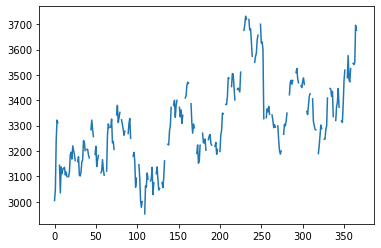

In [128]:
merged_df["AMZN"].plot()

<AxesSubplot:>

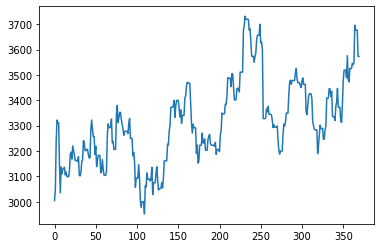

In [129]:
merged_df["AMZN"].interpolate(method='pad', limit=3).plot()

In [130]:
merged_df["AMZN"] = merged_df["AMZN"].interpolate(method='pad', limit=3)

In [132]:
merged_df.fillna(value=-1, inplace=True)

In [ ]:
#put the data which dont have to be scaled in the index

In [134]:
df_temp = merged_df.set_index(["date", "class_label"])

In [135]:
df_temp = df_temp[["AMZN"]]

### Scaling stocks

In [136]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled_temp = scaler.fit_transform(df_temp)


In [138]:
merged_df["AMZN"] = X_scaled_temp
merged_df.head(20)

,date,AMZN,class_label
0,2020-11-02,0.067393,0.000000
1,2020-11-03,0.123752,-1.000000
2,2020-11-04,0.371039,-1.000000
3,2020-11-05,0.474752,1.000000
4,2020-11-06,0.461114,0.333333
5,2020-11-07,0.461114,1.000000
6,2020-11-09,0.246055,0.250000
7,2020-11-10,0.106574,1.000000
8,2020-11-11,0.237908,0.000000
9,2020-11-12,0.203128,1.000000


In [139]:
df  = merged_df.copy()

In [141]:
df.head()

,date,AMZN,class_label
0,2020-11-02,0.067393,0.000000
1,2020-11-03,0.123752,-1.000000
2,2020-11-04,0.371039,-1.000000
3,2020-11-05,0.474752,1.000000
4,2020-11-06,0.461114,0.333333


## prepare it for model LSTM

In [142]:
df.set_index(["date"], inplace= True)

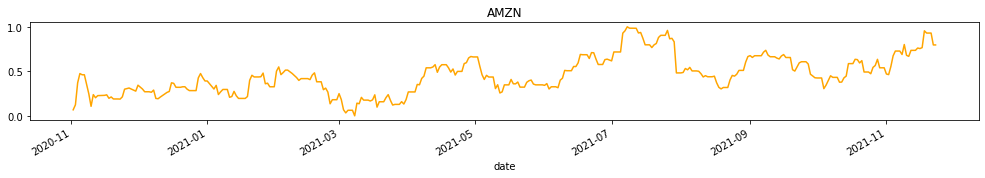

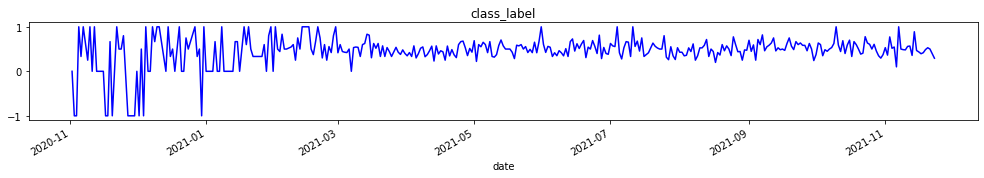

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

for col in df.columns:
    color="orange" if col == "AMZN" else "blue"
    df[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [145]:
df.describe()

,AMZN,class_label
count,370.000000,370.000000
mean,0.462176,0.467638
std,0.211097,0.334721
min,0.000000,-1.000000
25%,0.311446,0.360909
50%,0.445552,0.500000
75%,0.601166,0.605861
max,1.000000,1.000000


X.shape = number of sequence?, 30, 2 <br>
y.shape = number of sequence?

In [146]:
import numpy as np

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    # $CHALLENGIFY_END
    return df_sample

In [147]:
# Test it 
assert subsample_sequence(df, 10).shape == (10, 2)

In [148]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    # $CHALLENGIFY_BEGIN
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1]['AMZN'] # -1 means the future window
    
    X_sample = df_subsample[0:length -1]# -1 means the future window
    X_sample = X_sample.values
    # $CHALLENGIFY_END
    return np.array(X_sample), np.array(y_sample)

In [149]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['AMZN']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

In [150]:
# Test it
(X_sample, y_sample) = split_subsample_sequence(df, 10)
assert X_sample.shape == (9,2)
assert y_sample.shape == ()

In [151]:
def get_X_y(df, n_sequences, length): #length = 30, n_sequence = 12, df(12month)
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [153]:
X, y = get_X_y(df, 12, 30)
print(X.shape)
print(y.shape)

(12, 29, 2)
(12,)


## Train test split

In [154]:
# len of train dataset should be 80%

In [155]:
len_ = int(0.8*df.shape[0])
df_train = df[:len_]
df_test = df[len_:]
print(df_train.shape)
print(df_test.shape)

(296, 2)
(74, 2)


In [156]:
X_train, y_train = get_X_y(df_train, 12, 30) # 12 sequences of a length of 30 days
X_test, y_test = get_X_y(df_test, 12, 30) # 12 sequences of a length of 30 days

## predict a baseline

In [157]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 24 %


In [158]:
# Or (better) we predict the last pollution value!
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 11 %


## simple LSTM

In [42]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

2021-11-30 12:04:38.881843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 12:04:38.882025: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [43]:
model = init_model()
model.summary()

2021-11-30 12:04:51.486254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-30 12:04:51.486457: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-30 12:04:51.486580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-47G28MR): /proc/driver/nvidia/version does not exist
2021-11-30 12:04:51.487898: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 2)          5         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 20)                1840      
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,956
Trainable params: 1,951
Non-trainable params: 5
_________________________________________________________________


In [44]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 1.
Epoch 00011: early stopping


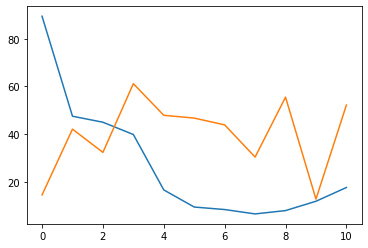

In [45]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])

In [46]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[1]:.0f} %')

MAPE on the test set : 62 %


## Improved Model

In [47]:
def init_model_2():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.005)
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train,
            validation_split=0.3,
            epochs=1000, 
            batch_size=32,
            callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 10.
Epoch 00015: early stopping


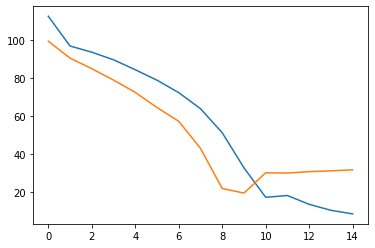

In [48]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['mean_absolute_percentage_error'])
plt.plot(history_2.history['val_mean_absolute_percentage_error'])

In [49]:
res = model_2.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[1]:.0f} %')

MAPE on the test set : 27 %


## Check Performance of the models

In [50]:
def train_model(nb_sequences=12, nb_days=30, plot_history=False):
    X_train, y_train = get_X_y(df_train, nb_sequences, nb_days)
    X_test, y_test = get_X_y(df_test, round(nb_sequences*0.2), nb_days)

    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)

    model = models.Sequential()
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=1000, 
            batch_size=64,
            callbacks=[es],
            verbose=0)

    if plot_history:
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.show()

    res = model.evaluate(X_test, y_test, verbose=0)
    return res

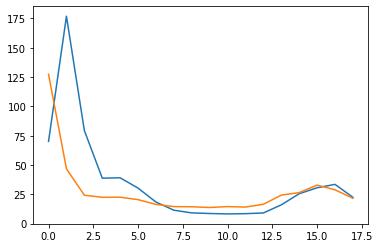

[0.00831606425344944, 14.130487442016602]

In [51]:
train_model(nb_sequences=12, nb_days=30, plot_history=True)

In [62]:
nb_days_grid = [12,30,60]
nb_sequences_grid = [12, 50, 100]
MAPE = []

In [66]:
for nb_days in nb_days_grid:
    for nb_sequences in nb_sequences_grid:
        res = train_model(nb_sequences=nb_sequences, nb_days=nb_days)
        MAPE.append((nb_days, nb_sequences, res[1]))
        print(f'For {nb_sequences} sequences and {nb_days} days of observation, the MAPE is of {res[1]:.0f} %')

For 12 sequences and 12 days of observation, the MAPE is of 9 %
For 50 sequences and 12 days of observation, the MAPE is of 18 %
For 100 sequences and 12 days of observation, the MAPE is of 13 %
For 12 sequences and 30 days of observation, the MAPE is of 22 %
For 50 sequences and 30 days of observation, the MAPE is of 10 %
For 100 sequences and 30 days of observation, the MAPE is of 11 %
For 12 sequences and 60 days of observation, the MAPE is of 14 %
For 50 sequences and 60 days of observation, the MAPE is of 7 %
For 100 sequences and 60 days of observation, the MAPE is of 19 %


In [71]:
MAPE

[(12, 12, 30.623857498168945),
 (12, 50, 22.42176628112793),
 (12, 100, 10.805002212524414),
 (30, 12, 48.83187484741211),
 (30, 50, 8.421904563903809),
 (30, 100, 16.333904266357422),
 (60, 12, 54.898162841796875),
 (60, 50, 17.427099227905273),
 (60, 100, 6.6427812576293945),
 (12, 100, 16.22715950012207),
 (30, 100, 13.879152297973633),
 (60, 100, 7.761134147644043),
 (12, 12, 9.168890953063965),
 (12, 50, 18.47922134399414),
 (12, 100, 12.610896110534668),
 (30, 12, 21.59432601928711),
 (30, 50, 9.587403297424316),
 (30, 100, 10.919512748718262),
 (60, 12, 13.678723335266113),
 (60, 50, 6.962544918060303),
 (60, 100, 19.122385025024414)]

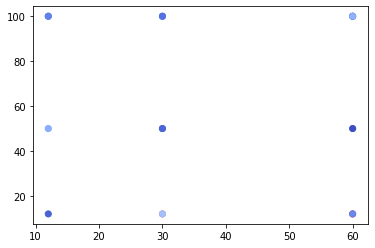

In [73]:
import matplotlib
x = [res[0] for res in MAPE] # n_days
y = [res[1] for res in MAPE] # n_seq
c = [res[2] for res in MAPE] # MAPE  
plt.scatter(x, y, c=c, norm=matplotlib.colors.Normalize(clip=False), cmap='coolwarm') # vmin=20, vmax=50, 

In [74]:
sns.heatmap(data= x, y, c=c)

NameError: name 'sns' is not defined

In [180]:
def train_model_predict(nb_sequences=12, nb_days=30, plot_history=False):
    X_train, y_train = get_X_y(df_train, nb_sequences, nb_days)
    X_test, y_test = get_X_y(df_test, round(nb_sequences*0.2), nb_days)

    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)

    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=1000, 
            batch_size=64,
            callbacks=[es],
            verbose=0)

    if plot_history:
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.show()

    res = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    return res, y_pred

In [181]:
result = train_model_predict(nb_sequences=12, nb_days=30, plot_history=False)


In [182]:
result

([0.001372073544189334, 7.653264999389648],
 array([[0.70298654],
        [0.33646587]], dtype=float32))

In [185]:
result_1  = result[1]
result_1.shape

(2, 1)

In [184]:
scaler.inverse_transform(result_1)

array([[3499.8997],
       [3214.2117]], dtype=float32)

In [176]:
y_test.shape

(12,)